# Analyze GOC COI Data: Banzai and USEARCH COI

- Plot Top 20 Families Across both Datasets
- Look at top level of assignment

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

#For illustrator import:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [2]:
#Functions

#Raw Read Numbers
def make_rawread(infile):
    #infile = OTU_table_taxa_all.txt
    df = pd.read_csv(infile, sep='\t')
    df.rename(columns={'DUP_ID':'OTU'}, inplace=True)
    df.drop('taxonomy', axis=1, inplace=True)
    df.drop('repseq', axis=1, inplace=True)
    df.set_index('OTU', inplace=True)
    return df
    
#metadata handling and sample order
def make_metadata(infile):
    df = pd.read_csv(infile)
    #make all column names with underscore
    columns_l = list(df)
    columns_l = [c.replace('-', '_') for c in columns_l]
    df.columns = columns_l
    #extract site name
    df['site'] = df['sample_name'].str.extract('([a-zA-Z0-9]+)')
    df_full = df[:]
    #add in some missing location data
    df_full.loc[df_full['site']=='UC5', 'dec_lat'] = 32
    df_full.loc[df_full['site']=='UC5', 'dec_long'] = '.118.17'
    df_full['dec_long'] = df_full['dec_long'].str.replace('^\.','-')
    df_full.set_index('sample_name', inplace=True)
    df= df[['Description', 'Treatment', 'sample_name']]
    df['comb'] = df['Description']+'_'+df['Treatment']+'_'+df['sample_name']
    df['site_Order']=df['sample_name'].str.replace('GOC2a', '16').str.replace('GOC2b', '17').str.replace('NTC', '0')
    df['site_Order']=df['site_Order'].str.extract('(\d+)')
    df.set_index('sample_name', inplace=True)
    df['site_Order']= df['site_Order'].astype(int)
    df.sort_values('site_Order', ascending=True, inplace=True)
    return df_full, df

#DESEQ Numbers
def make_deseq(infile):
    df = pd.read_csv(infile, sep=',')
    df.rename(columns={'Unnamed: 0':'OTU'}, inplace=True)
    df.set_index('OTU', inplace=True)
    return df

#Rarefied Read Numbers (From R script); make compositional
def make_rarereads_comp(infile):
    df= pd.read_csv(infile, sep=',')
    df.rename(columns={'Unnamed: 0':'OTU'}, inplace=True)
    df.set_index('OTU', inplace=True)
    df=df.T
    df['Total']=df.sum(axis=1)
    tot_reads = df['Total'].tolist()
    tot_reads = set(tot_reads)
    print('Rarefied read count:', tot_reads)
    tot_reads = df['Total'].tolist()[0]
    df = df/tot_reads *100
    df.drop('Total', axis=1, inplace=True)
    df=df.T
    return df

def make_rarereads(infile):
    df= pd.read_csv(infile, sep=',')
    df.rename(columns={'Unnamed: 0':'OTU'}, inplace=True)
    df.set_index('OTU', inplace=True)
    return df

#Taxa table
def make_taxa(infile):
    #infile = OTU_table_taxa_all.txt
    df = pd.read_csv(infile, sep='\t')
    df.rename(columns={'DUP_ID':'OTU'}, inplace=True)
    df = df[['taxonomy', 'OTU']]
    df.set_index('OTU', inplace=True)
    df['Kingdom']=df['taxonomy'].str.split("\'").str[1]
    df['Phylum']=df['taxonomy'].str.split("\'").str[3]
    df['Class']=df['taxonomy'].str.split("\'").str[5]
    df['Order']=df['taxonomy'].str.split("\'").str[7]
    df['Family']=df['taxonomy'].str.split("\'").str[9]
    df['Genus']=df['taxonomy'].str.split("\'").str[11]
    df['Species']=df['taxonomy'].str.split("\'").str[13]
    df=df.drop('taxonomy', axis=1)
    return df

#Filtered Taxa table
def make_Ftaxa(infile):
    df = pd.read_csv(infile, sep=',')
    df.rename(columns={'OTU_ID':'OTU'}, inplace=True)
    df.set_index('OTU', inplace=True)
    df=df[df.columns[-7:]]
    return df

#extract sequences
def make_seq(infile):
    #infile = OTU_table_taxa_all.txt
    df = pd.read_csv(infile, sep='\t')
    df.rename(columns={'DUP_ID':'OTU'}, inplace=True)
    df.set_index('OTU', inplace=True)
    df=df[['repseq']]
    return df

# Import Banzai Results

In [3]:
#COI M6
print('COI')
#OTU_table_taxa_all.txt location
file_loc1 = '/Users/kpitz/Projects/Gulf_of_California/Cutadapt_Results/COI/Analysis_20190921_1416/all_lib/Post_Blast_20190925_0914/OTU_table_taxa_all.txt'
#metadata
meta_file = '/Users/kpitz/Projects/Gulf_of_California/Cutadapt_Results/COI/Analysis_20190921_1416/GOC_20190921_1416_COI_analysis_metadata.csv'

#DESEQ data
#file2 = '/Users/kpitz/Projects/Gulf_of_California/Deseq/COI_GOC_DEseq_122117.csv'
#rarefied data
file3 = '/Users/kpitz/Projects/MBON/Rarefied_Data_unmerged/GOC_COI_OTU_Table_092619_M6.csv'
#Filtered OTU table
file4 ='/Users/kpitz/Projects/Gulf_of_California/Cutadapt_Results/COI/Analysis_20190921_1416/all_lib/Filtered_OTU_taxa_table_all.csv'

raw_COI = make_rawread(file_loc1)
meta_COI, samp_lim_COI = make_metadata(meta_file)
#deseq_COI = make_deseq(file2)
rare_COI = make_rarereads(file3)
rare_comp_COI = make_rarereads_comp(file3)
taxa_COI = make_taxa(file_loc1)
Ftaxa_COI = make_Ftaxa(file4)
seq_COI = make_seq(file_loc1)

#Directory for saving Figures
plot_dir = '/Users/kpitz/Projects/Gulf_of_California/GOC_18S_COI_Combined_Cutadapt/'
plot_name = 'GOC_18SCOI_'
Plot_str = plot_dir + plot_name
print(Plot_str)

#Use to change the name of the databases
name1 = 'GOC_18SCOI_'

COI
Rarefied read count: {129363}
/Users/kpitz/Projects/Gulf_of_California/GOC_18S_COI_Combined_Cutadapt/GOC_18SCOI_


# Import Filtered Banzai Results

Created in GOC_COI_Filter_Data.ipynb

- /Users/kpitz/Projects/Gulf_of_California/Decontaminated_tables/GOC_COI_seq_table_092519.csv
- /Users/kpitz/Projects/Gulf_of_California/Decontaminated_tables/GOC_COI_otu_table_092519.csv
- /Users/kpitz/Projects/Gulf_of_California/Decontaminated_tables/GOC_COI_taxa_table_092519.csv

In [4]:
files = ['/Users/kpitz/Projects/Gulf_of_California/Decontaminated_tables/GOC_COI_seq_table_092519.csv',
         '/Users/kpitz/Projects/Gulf_of_California/Decontaminated_tables/GOC_COI_otu_table_092519.csv',
         '/Users/kpitz/Projects/Gulf_of_California/Decontaminated_tables/GOC_COI_taxa_table_092519.csv']
#dfs = [seq_COI_filt, raw_COI_filt, Ftaxa_COI_filt]
df = pd.read_csv(files[0])
df.set_index('Unnamed: 0', inplace=True)
df.index.rename('OTU', inplace=True)
seq_COI_filt = df.copy()

df = pd.read_csv(files[1])
df.set_index('Unnamed: 0', inplace=True)
df.index.rename('OTU', inplace=True)
raw_COI_filt = df.copy()

df = pd.read_csv(files[2])
df.set_index('Unnamed: 0', inplace=True)
df.index.rename('OTU', inplace=True)
Ftaxa_COI_filt = df.copy()

raw_COI_filt.head()

#import metadata
meta_file ='/Users/kpitz/Projects/Gulf_of_California/Combined_PCTD_Metadata_043019.csv'
df= pd.read_csv(meta_file)
df=df.sort_values(['order'])
df.set_index('sample_ID', inplace=True)
print(list(df))

meta_COI_PCTD = df.copy()
meta_COI_PCTD

['order', 'tag_sequence', 'primer_sequence_F', 'primer_sequence_R', 'library_tag_combo', 'library', 'sample_type', 'locus', 'tag_number', 'R1', 'R2', 'Treatment', 'Time_of_Day', 'Description', 'Description_3', 'site', 'SEQ', 'BOTTLE', 'DEPTH', 'CRUISE', 'PLATFORM', 'DEC_LAT', 'DEC_LONG', 'TMP', 'SAL', 'CHL_GFF', 'PRESSURE', 'NO3', 'OXY_ML', 'RDEP', 'TRANSMISS', 'SIG_T', 'FLUOR', 'DATE_TIME', 'cruise', 'SEQAvg_dg', 'AvgOfTMP', 'StDevOfTMP', 'CountOfTMP', 'AvgOfSAL1', 'StDevOfSAL', 'CountOfSAL', 'AvgOfCHLA', 'StDevOfCHLA', 'CountOfCHLA', 'AvgOfOXY_ML1', 'CountOfOXY_ML1', 'CountOfOXY_ML', 'AvgOfTRANSMISS', 'StDevOfTRANSMISS', 'CountOfTRANSMISS', 'AvgOfSIGMA_THETA', 'StDevOfSIGMA_THETA', 'CountOfSIGMA_THETA']


,order,tag_sequence,primer_sequence_F,primer_sequence_R,library_tag_combo,library,sample_type,locus,tag_number,R1,...,CountOfCHLA,AvgOfOXY_ML1,CountOfOXY_ML1,CountOfOXY_ML,AvgOfTRANSMISS,StDevOfTRANSMISS,CountOfTRANSMISS,AvgOfSIGMA_THETA,StDevOfSIGMA_THETA,CountOfSIGMA_THETA
sample_ID,,,,,,,,,,,,,,,,,,,,,
UC1,1.0,TTCTAGCT,CACGACGTTGTAAAACGAC,GGATAACAATTTCACACAGG,N7_TTCTAGCT,N7,environmental,COI,1,UC1-COI_S22_L001_R1_001.fastq.gz,...,101,4.649444,101,101,88.565879,1.576289,101,25.500296,0.326118,101
UC2,2.0,CCTAGAGT,CACGACGTTGTAAAACGAC,GGATAACAATTTCACACAGG,N8_CCTAGAGT,N8,environmental,COI,2,UC2-COI_S23_L001_R1_001.fastq.gz,...,100,4.906637,100,100,88.278839,1.773990,100,25.359315,0.297979,100
UC3,3.0,GCGTAAGA,CACGACGTTGTAAAACGAC,GGATAACAATTTCACACAGG,N11_GCGTAAGA,N11,environmental,COI,3,UC3-COI_S24_L001_R1_001.fastq.gz,...,100,3.438635,100,100,89.038490,2.019294,100,25.820711,0.395819,100
UC3_1,3.2,GCGTAAGA,CACGACGTTGTAAAACGAC,GGATAACAATTTCACACAGG,N9_GCGTAAGA,N9,environmental,COI,19,UC3-1-COI_S40_L001_R1_001.fastq.gz,...,100,3.438635,100,100,89.038490,2.019294,100,25.820711,0.395819,100
UC3_2,3.3,TTCTAGCT,CACGACGTTGTAAAACGAC,GGATAACAATTTCACACAGG,N10_TTCTAGCT,N10,environmental,COI,17,UC3-2-COI_S38_L001_R1_001.fastq.gz,...,100,3.438635,100,100,89.038490,2.019294,100,25.820711,0.395819,100
UC4,4.0,CTATTAAG,CACGACGTTGTAAAACGAC,GGATAACAATTTCACACAGG,N12_CTATTAAG,N12,environmental,COI,4,UC4-COI_S25_L001_R1_001.fastq.gz,...,100,4.150925,100,100,87.901410,2.446235,100,25.241416,0.387431,100
UC5,5.0,AAGGCTAT,CACGACGTTGTAAAACGAC,GGATAACAATTTCACACAGG,N13_AAGGCTAT,N13,environmental,COI,5,UC5-COI_S26_L001_R1_001.fastq.gz,...,100,3.960167,100,100,88.774005,1.737731,100,25.364624,0.407508,100
UC6,6.0,GAGCCTTA,CACGACGTTGTAAAACGAC,GGATAACAATTTCACACAGG,N14_GAGCCTTA,N14,environmental,COI,6,UC6-COI_S27_L001_R1_001.fastq.gz,...,101,4.433089,101,101,88.352917,1.047110,101,25.079593,0.394927,101
UC7,7.0,TTATGCGA,CACGACGTTGTAAAACGAC,GGATAACAATTTCACACAGG,N15_TTATGCGA,N15,environmental,COI,7,UC7-COI_S28_L001_R1_001.fastq.gz,...,100,3.935789,100,100,87.597776,1.543175,100,25.256188,0.434631,100


# Import USEARCH Data

In [5]:
#rarefied datasets
Geller_18S = pd.read_csv('/Users/kpitz/Projects/Gulf_of_California/Geller_lab_data/18S_Geller_MGmodified_9Jan19.txt', sep='	')
Geller_18S
#original 18S before mistake fixed (OTU_67 included and taxonomy wrong- sequences also wrong)
#Geller_18So = pd.read_csv('/Users/kpitz/Projects/Gulf_of_California/Geller_lab_data/Incorrect_18S/18S_Geller.txt', sep='	')
#Geller_18So
Geller_COI = pd.read_csv('/Users/kpitz/Projects/Gulf_of_California/Geller_lab_data/COI_Geller.txt', sep='	')
Geller_COI

#non-rarefied datasets
file= '/Users/kpitz/Projects/Gulf_of_California/Geller_lab_data/Not_rarefied/MBARI_18S_otu_table_10097_txt.txt'
Geller_18S_nr = pd.read_csv(file, sep='	')
Geller_18S_nr
file= '/Users/kpitz/Projects/Gulf_of_California/Geller_lab_data/Not_rarefied/MBARI_COI_otu_table_10095_txt.txt'
Geller_COI_nr = pd.read_csv(file, sep='	')
Geller_18S.head()




,#OTU ID,CP23_1,CP23,CP23_2,GOC2a,UC10,UC1,UC12,UC13,UC14,...,UC9,Sequence,Kingdom,Phylum,Class,Order,Family,Genus,Species,OrganismDescriptionFromGenBank
0,OTU_1,1,1,0,0,58,64,0,0,1,...,1,ATGCATGTCTAAGTACAGGCCTAAGCAAGGCGAAACCGCGAATGGC...,Animalia,Arthropoda,Malacostraca,Euphausiacea,Euphausiidae,Nematoscelis,difficilis,Nematoscelis difficilis
1,OTU_10,21,23,35,1,0,0,222,4,0,...,0,ATGCATGTCTAAGTATAAACTTTTATACTGTGAAACTGCGAATGGC...,Animalia,Ctenophora,Tentaculata,Lobata,Ocyropsidae,Ocyropsis,inerme,Ocyropsis sp.
2,OTU_100,1,0,0,2,0,0,0,0,0,...,0,ATGCATATCTAAATGCTTTGTTTTTATAACATTAGATTGCGGACGG...,Protista,Radiozoa,Polycystinea,Collodaria,Sphaerozoidae,Collozoum,NaN,Collozoum inerme
3,OTU_101,0,0,0,0,0,3,0,0,0,...,0,ATGCATGTCTAAGTACAGGCCTAAGCAAGGCGAAACTGCGAATAGC...,Animalia,Arthropoda,Malacostraca,Euphausiacea,Euphausiidae,Nematoscelis,NaN,Nematoscelis difficilis
4,OTU_102,0,1,0,0,0,0,0,0,0,...,0,ATGCATGTCTAAGTACAAGCTCGTCTCGAGCGAAACTGCGGATGGC...,Animalia,Echinodermata,Echinoidea,Echinoida,Echinometridae,Heliocidaris,NaN,Anthocidaris crassispina


In [6]:
#Make compositional rarefied OTU table and taxa table
# Format Geller Data to get OTU table / taxa table
print(list(Ftaxa_COI))
#levels = list(Ftaxa_COI)
levels =['Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
df = Geller_COI.copy()
df['Species'] = df['Genus'] + ' ' + df['Species']
df.fillna('no hits', inplace=True)
df['Class']=df['Class'].str.replace('Maxillopoda', 'Hexanauplia')
df.set_index('#OTU ID', inplace=True)

df[levels]=df[levels].astype(str)
#get rid of white space
for i in levels:
    df[i]=df[i].str.strip()

cols = list(df)
for i in range(len(cols)):
    cols[i] = cols[i].replace('.','_')
df.columns = cols

Geller_COI_taxa = df[levels]

Geller_COI_otu = df[['CP23_1', 'CP23', 'CP23_2', 'GOC2a', 'GOC2b', 'UC10', 'UC1', 'UC12', 'UC13', 
                     'UC14', 'UC15', 'UC2', 'UC3_1', 'UC3', 'UC3_2', 'UC4', 'UC5', 'UC6', 'UC7', 'UC9']]
print(list(df))
#This is rarefied data. Create a percent rarefied data OTU table
df = Geller_COI_otu.copy()
df=df.T
cols = list(df)
df['tot']=df.sum(axis=1)
for i in cols:
    df[i]=df[i]/df['tot'] *100
df.drop('tot', axis=1, inplace=True)
df=df.T
Geller_COI_otu_comp = df.copy()
df

['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
['CP23_1', 'CP23_2', 'CP23', 'GOC2a', 'GOC2b', 'UC10', 'UC12', 'UC13', 'UC14', 'UC15', 'UC1', 'UC2', 'UC3_1', 'UC3_2', 'UC3', 'UC4', 'UC5', 'UC6', 'UC7', 'UC9', 'Sequence', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']


,CP23_1,CP23,CP23_2,GOC2a,GOC2b,UC10,UC1,UC12,UC13,UC14,UC15,UC2,UC3_1,UC3,UC3_2,UC4,UC5,UC6,UC7,UC9
#OTU ID,,,,,,,,,,,,,,,,,,,,
OTU_1,0.212719,0.245167,0.060691,9.074794,7.174748,0.189884,0.000000,1.415120,1.799095,1.382671,4.411208,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000601,0.000000
OTU_10,1.819526,1.790682,1.089432,0.116575,0.146620,2.282219,0.000000,6.706046,8.487715,5.893629,14.037027,0.000000,0.000000,0.000000,0.015623,0.001803,0.000000,0.016224,0.000000,0.243965
OTU_100,0.183275,0.233750,0.144817,0.036655,0.000000,0.182674,0.000000,0.007812,0.198297,0.003005,0.044467,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OTU_1000,0.000000,0.000000,0.000000,0.004807,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OTU_1001,0.000000,0.000000,0.000000,0.000000,0.002404,0.000000,0.000000,0.000000,0.000000,0.000000,0.000601,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OTU_1002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.194692,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OTU_1003,0.000000,0.000000,0.000000,0.096144,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OTU_1004,0.000000,0.000000,0.000000,0.009014,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OTU_1005,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013821,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Format Metadata

In [7]:
meta_dat = meta_COI.reset_index()
print(list(meta_dat))
#meta_dat['site']= meta_dat.sample_name.str.split('.').str[:-1].str.join('.')
meta_dat['site_Order']=meta_dat['site'].str.replace('GOC2a', '16').str.replace('GOC2b', '17').str.replace('NTC', '0')
meta_dat['site_Order']=meta_dat['site_Order'].str.extract('(\d+)')
meta_dat['site_Order']=meta_dat['site_Order'].astype(int)
meta_dat= meta_dat.loc[meta_dat['sample_type']=='environmental']
meta_dat.sort_values(['site_Order', 'sample_name'], inplace=True)
meta_dat['sample_name']=meta_dat['sample_name'].str.replace('_COI','')
meta_dat['sample_name']=meta_dat['sample_name'].str.replace('.','_')
meta_dat.set_index('sample_name', inplace=True)

meta_dat

['sample_name', 'order', 'tag_sequence', 'tag_sequence_orig', 'primer_sequence_F', 'primer_sequence_R', 'library_tag_combo', 'library', 'sample_type', 'locus', 'tag_number', 'R1', 'R2', 'Treatment', 'depth', 'dec_lat', 'dec_long', 'fluor', 'tmp', 'sal', 'sigma_theta', 'conduct', 'oxy_ml', 'transmiss', 'Description', 'site']


,order,tag_sequence,tag_sequence_orig,primer_sequence_F,primer_sequence_R,library_tag_combo,library,sample_type,locus,tag_number,...,fluor,tmp,sal,sigma_theta,conduct,oxy_ml,transmiss,Description,site,site_Order
sample_name,,,,,,,,,,,,,,,,,,,,,
UC1,1,TTCTAGCT_AA,TTCTAGCT,GGWACWGGWTGAACWGTWTAYCCYCC,TANACYTCNGGRTGNCCRAARAAYCA,N7_TTCTAGCT,N7,environmental,COI,1,...,0.317525,12.57277917,33.31300833,25.17000417,3.879983208,5.731966667,86.42458333,PCNorth,UC1,1
UC2,2,CCTAGAGT_AA,CCTAGAGT,GGWACWGGWTGAACWGTWTAYCCYCC,TANACYTCNGGRTGNCCRAARAAYCA,N8_CCTAGAGT,N8,environmental,COI,2,...,0.327413043,12.72407391,33.28353913,25.11782174,3.890925304,5.685595652,85.7651913,PCNorth,UC2,2
UC3_1,19,GCGTAAGA_AT,GCGTAAGA,GGWACWGGWTGAACWGTWTAYCCYCC,TANACYTCNGGRTGNCCRAARAAYCA,N9_GCGTAAGA,N9,environmental,COI,19,...,0.351265217,12.57266522,33.42426522,25.25619565,3.891625217,5.249904348,85.76833913,PCNorth,UC3,3
UC3_2,17,TTCTAGCT_AT,TTCTAGCT,GGWACWGGWTGAACWGTWTAYCCYCC,TANACYTCNGGRTGNCCRAARAAYCA,N10_TTCTAGCT,N10,environmental,COI,17,...,0.351265217,12.57266522,33.42426522,25.25619565,3.891625217,5.249904348,85.76833913,PCNorth,UC3,3
UC3,3,GCGTAAGA_AA,GCGTAAGA,GGWACWGGWTGAACWGTWTAYCCYCC,TANACYTCNGGRTGNCCRAARAAYCA,N11_GCGTAAGA,N11,environmental,COI,3,...,0.351265217,12.57266522,33.42426522,25.25619565,3.891625217,5.249904348,85.76833913,PCNorth,UC3,3
UC4,4,CTATTAAG_AA,CTATTAAG,GGWACWGGWTGAACWGTWTAYCCYCC,TANACYTCNGGRTGNCCRAARAAYCA,N12_CTATTAAG,N12,environmental,COI,4,...,0.234636364,14.71248182,33.41780455,24.81468182,4.091150818,5.4555,84.71545455,EUNorth,UC4,4
UC5,5,AAGGCTAT_AA,AAGGCTAT,GGWACWGGWTGAACWGTWTAYCCYCC,TANACYTCNGGRTGNCCRAARAAYCA,N13_AAGGCTAT,N13,environmental,COI,5,...,na,na,na,na,na,na,na,EUNorth,UC5,5
UC6,6,GAGCCTTA_AA,GAGCCTTA,GGWACWGGWTGAACWGTWTAYCCYCC,TANACYTCNGGRTGNCCRAARAAYCA,N14_GAGCCTTA,N14,environmental,COI,6,...,0.217382609,15.64703043,33.51538696,24.68554348,4.190452652,5.243447826,88.00826957,EUNorth,UC6,6
UC7,7,TTATGCGA_AA,TTATGCGA,GGWACWGGWTGAACWGTWTAYCCYCC,TANACYTCNGGRTGNCCRAARAAYCA,N15_TTATGCGA,N15,environmental,COI,7,...,0.233269565,15.32267826,33.46879565,24.72148696,4.154456522,5.334295652,86.80058696,EUNorth,UC7,7


# Look at top 20 Families across Banzai and USEARCH Datasets

['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
['Phylum', 'Class', 'Order', 'Family', 'Genus']


/Users/kpitz/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:54: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/kpitz/anaconda/lib/python3.5/site-packages/pandas/core/generic.py:3111: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/Users/kpitz/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2662: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
/Users/kpitz/anaconda/lib/python3.5/site-packages/pandas/plotting/_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being de

315
/Users/kpitz/Projects/Gulf_of_California/GOC_18S_COI_Combined_Cutadapt/GOC_COI_Banzai_Usearch_top20Fam_rare.pdf


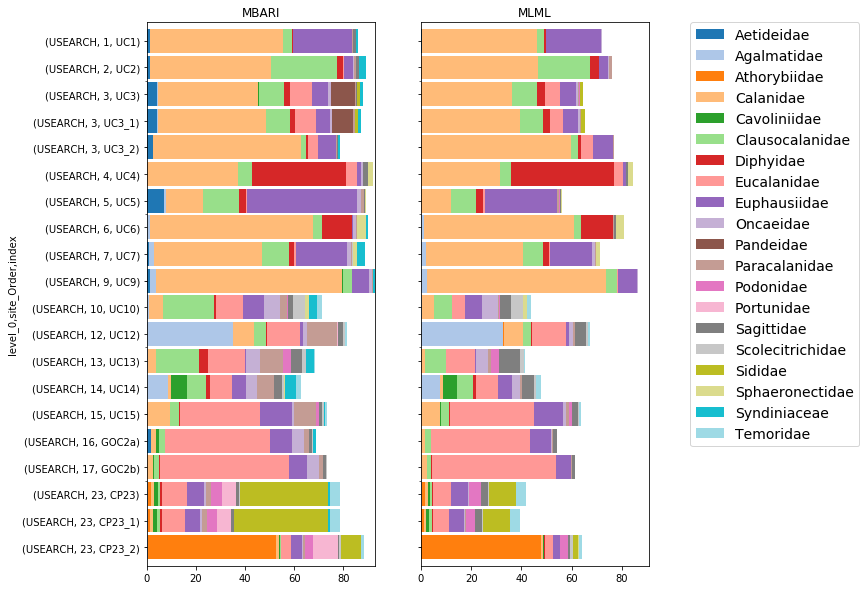

index                      Aetideidae  Agalmatidae  Athorybiidae  Calanidae  \
level_0 site_Order index                                                      
Banzai  23         CP23_2    0.199439     0.105131     52.335676   1.045121   
                   CP23_1    0.020098     0.272103      1.103097   1.029661   
                   CP23      0.008503     0.282925      1.407667   1.107736   
        17         GOC2b     0.000773     0.046381      0.000000   2.600434   
        16         GOC2a     1.668947     0.034013      0.000000   1.920178   
        15         UC15      0.019325     0.068799      0.000000   9.195829   
        14         UC14      0.001546     8.643121      0.000773   1.217504   
        13         UC13      0.037878     0.452216      0.000000   3.320888   
        12         UC12      0.000000    35.044023      0.011595   8.772215   
        10         UC10      0.000773     0.768380      0.000000   5.848658   
        9          UC9       1.332684     2.332197      0.000000  75.862495   
        7          UC7       0.789252     2.290454      0.000000  43.982437   
        6          UC6       0.000000     1.406121      0.000000  66.369055   
        5          UC5       7.153514     0.504781      0.000000  15.319682   
        4          UC4       0.000000     0.115953      0.000000  36.968840   
        3          UC3_2     2.419548     0.109769      0.000000  60.135433   
                   UC3_1     3.941622     0.534929      0.000773  43.887356   
                   UC3       3.971769     0.466130      0.000000  40.928241   
        2          UC2       1.275481     0.139916      0.006184  49.129195   
        1          UC1       1.140975     0.081940      0.000000  54.069556   

index                      Cavoliniidae  Clausocalanidae  Diphyidae  \
level_0 site_Order index                                              
Banzai  23         CP23_2      0.602954         0.242728   0.092762   
                   CP23_1      1.894668         1.051305   0.739006   
                   CP23        1.554540         0.899021   0.852639   
        17         GOC2b       0.177794         2.135077   0.305342   
        16         GOC2a       1.147933         2.571833   0.071891   
        15         UC15        0.233452         3.678795   0.327760   
        14         UC14        6.424557         7.799757   1.739292   
        13         UC13        0.001546        17.586945   3.392005   
        12         UC12        0.000773         4.788077   0.228040   
        10         UC10        0.046381        20.767144   0.879695   
        9          UC9         0.143008         3.838810   0.012368   
        7          UC7         0.000000        10.673067   2.162133   
        6          UC6         0.000000         3.381956  12.485796   
        5          UC5         0.000000        14.371961   2.843935   
        4          UC4         0.000000         5.571918  38.497870   
        3          UC3_2       0.000773         2.193054   0.943083   
                   UC3_1       0.339355         9.530546   2.156722   
                   UC3         0.321576        10.101034   2.557918   
        2          UC2         0.000000        26.686920   2.755038   
        1          UC1         0.000000         3.644009   0.582856   

index                      Eucalanidae  Euphausiidae  Oncaeidae  Pandeidae  \
level_0 site_Order index                                                     
Banzai  23         CP23_2     4.188215      4.529116   0.337036   0.002319   
                   CP23_1     9.487257      6.198063   0.459173   0.002319   
                   CP23      10.187612      7.151968   0.476179   0.008503   
        17         GOC2b     52.630196      7.357591   4.934177   0.000000   
        16         GOC2a     42.601826      9.219019   4.805083   0.000000   
        15         UC15      32.690955     12.693738   1.188130   0.000000   
        14         UC14       8.717330      5.827014   4.309578   0.000000

In [8]:
from palettable.tableau import Tableau_20 as pr
colors=pr.mpl_colors
cmap=pr.mpl_colormap

print(list(Ftaxa_COI))
#levels = list(Ftaxa_COI)
levels =['Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']

grouped = levels[:5]
print(grouped)

df = pd.concat([Geller_COI_otu_comp, Geller_COI_taxa], axis=1)
df=df.loc[df['Family']!='no hits']
df[levels]=df[levels].astype(str)
#group at Family level
#df=df.groupby(levels[:5]).sum()
df=df.groupby('Family').sum()
df=df.T
df=df.reset_index()
df=df.join(meta_dat[['site_Order']], on='index')
df.set_index(['site_Order', 'index'], inplace=True)
df=df.T
#df['tot'] = df.sum(axis=1)
#df=df.sort_values('tot', ascending=False)
#df.drop('tot', axis=1, inplace=True)
#df=df.head(n=20)
usearch_df = df.copy()



df = pd.concat([rare_comp_COI, Ftaxa_COI_filt.fillna('not assigned')],  axis=1, join='inner')
df=df.loc[df['Family'].isin(['f_', 'not assigned', 'unknown'])==False]
#make unknown no hits
#for i in levels:
#    df[i].str.replace('unknown','no hits')

df[levels]=df[levels].astype(str)
#get rid of white space


#group at Family level
#df=df.groupby(levels[:5]).sum()
df=df.groupby('Family').sum()
df=df.T
df=df.reset_index()
df=df.join(meta_dat[['site_Order']], on='index')
df.set_index(['site_Order', 'index'], inplace=True)
df=df.T
#df['tot'] = df.sum(axis=1)
#df=df.sort_values('tot', ascending=False)
#df.drop('tot', axis=1, inplace=True)
#df=df.head(n=20)
#usearch_df = df.copy()
df=pd.concat([df, usearch_df], keys=['Banzai', 'USEARCH'], axis=1)
#df=df.T


#Need to make taxa align - no Kingdom level
df=df.reset_index()
#df=df.groupby(levels[1:5]).sum()
#df=df.groupby('Family').sum()
df=df.groupby('index').sum()
df=df.sort_index()
#print(list(df))
print(len(df.index))
#df.reset_index(inplace=True)
#print(df['Phylum'].unique())
#df = df[[('Banzai', 'tot'),('USEARCH', 'tot')]]
df['total']=df.sum(axis=1)
df=df.sort_values('total', ascending=False)
df=df.head(n=20)
#print(list(df))
df.drop(('total', ''), axis=1, inplace=True)
df.sort_index(inplace=True)
df=df.T
df=df.sort_index(ascending=False)
df.reset_index(inplace=True)
df1=df.loc[df['level_0']=='Banzai']
df2=df.loc[df['level_0']=='USEARCH']

df1.set_index(['level_0', 'site_Order', 'index'], inplace=True)
df2.set_index(['level_0', 'site_Order', 'index'], inplace=True)

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)

df1.plot(kind='barh', stacked=True, colors=colors, ax=ax1, legend=False,figsize=(9,10), linewidth=.5, width=0.9)
ax1.set_title('MBARI')
df2.plot(kind='barh', stacked=True, colors=colors, ax=ax2,figsize=(9,10), linewidth=.5, width=0.9)
ax2.set_title('MLML')
plt.legend(bbox_to_anchor=(1.18, 1), loc=2, borderaxespad=0.,ncol=1, fontsize='14')

filename=plot_dir +'GOC_COI_Banzai_Usearch_top20Fam_rare.pdf'
print(filename)
plt.savefig(filename,dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape', papertype=None, format=None,
        transparent=True, bbox_inches='tight', pad_inches=1,
        frameon=None)

plt.show()
df1

['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
['Phylum', 'Class', 'Order', 'Family', 'Genus']


/Users/kpitz/anaconda/lib/python3.5/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/Users/kpitz/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:41: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/kpitz/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2662: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


319


/Users/kpitz/anaconda/lib/python3.5/site-packages/pandas/plotting/_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


/Users/kpitz/Projects/Gulf_of_California/GOC_18S_COI_Combined_Cutadapt/GOC_COI_Banzai_Usearch_top20FamPhy_rare.pdf


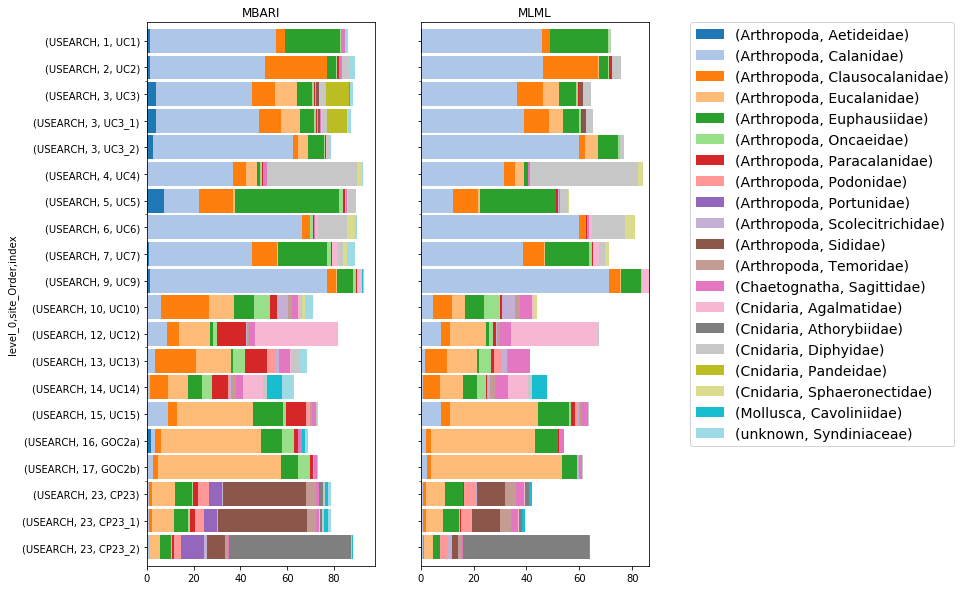

('level_0', '', '')  level_0 site_Order   index Arthropoda             \
('level_1', '', '')                             Aetideidae  Calanidae   
0                    USEARCH         23  CP23_2   0.000601   0.998696   
1                    USEARCH         23  CP23_1   0.000000   0.889933   
2                    USEARCH         23    CP23   0.000000   0.924785   
3                    USEARCH         17   GOC2b   0.000000   2.505153   
4                    USEARCH         16   GOC2a   0.000000   1.817723   
5                    USEARCH         15    UC15   0.000601   7.714356   
6                    USEARCH         14    UC14   0.000000   0.970454   
7                    USEARCH         13    UC13   0.000000   1.741409   
8                    USEARCH         12    UC12   0.000000   7.609199   
9                    USEARCH         10    UC10   0.000000   4.790977   
10                   USEARCH          9     UC9   0.034251  71.231905   
11                   USEARCH          7     UC7   0.000000  38.533924   
12                   USEARCH          6     UC6   0.000000  59.744497   
13                   USEARCH          5     UC5   0.037857  12.040837   
14                   USEARCH          4     UC4   0.000000  31.579706   
15                   USEARCH          3   UC3_2   0.000000  59.766731   
16                   USEARCH          3   UC3_1   0.035453  39.184098   
17                   USEARCH          3     UC3   0.041462  36.290163   
18                   USEARCH          2     UC2   0.020431  46.334810   
19                   USEARCH          1     UC1   0.347921  45.597505   
20                    Banzai         23  CP23_2   0.199439   1.045121   
21                    Banzai         23  CP23_1   0.020098   1.029661   
22                    Banzai         23    CP23   0.008503   1.107736   
23                    Banzai         17   GOC2b   0.000773   2.600434   
24                    Banzai         16   GOC2a   1.668947   1.920178   
25                    Banzai         15    UC15   0.019325   9.195829   
26                    Banzai         14    UC14   0.001546   1.217504   
27                    Banzai         13    UC13   0.037878   3.320888   
28                    Banzai         12    UC12   0.000000   8.772215   
29                    Banzai         10    UC10   0.000773   5.848658   
30                    Banzai          9     UC9   1.332684  75.862495   
31                    Banzai          7     UC7   0.789252  43.982437   
32                    Banzai          6     UC6   0.000000  66.369055   
33                    Banzai          5     UC5   7.153514  15.319682   
34                    Banzai          4     UC4   0.000000  36.968840   
35                    Banzai          3   UC3_2   2.419548  60.135433   
36                    Banzai          3   UC3_1   3.941622  43.887356   
37                    Banzai          3     UC3   3.971769  40.928241   
38                    Banzai          2     UC2   1.275481  49.129195   
39                    Banzai          1     UC1   1.140975  54.069556   

('level_0', '', '')                                                     \
('level_1', '', '') Clausocalanidae Eucalanidae Euphausiidae Oncaeidae   
0                          0.260190    3.223829     2.746114  0.106960   
1                          1.136903    6.534188     5.950113  0.287831   
2                          0.990283    7.135689     6.843652  0.273410   
3                          1.542511   49.534002     5.709753  0.115373   
4                          2.064693   39.447292     8.440243  0.289634   
5                          3.337399   33.432282    11.679095  0.877314   
6                          6.195881    8.730478     5.389473  3.225632   
7                          8.265982   11.283703     0.594891  4.538599   
8                          3.356027   13.684900     1.221029  1.550923   
9                          7.105644    5.018117     6.954217  6.245155   
10                         4.191879    0.1982

In [10]:
#Plot by Family and Phylum, fill nan in Ftaxa_COI
from palettable.tableau import Tableau_20 as pr
colors=pr.mpl_colors
cmap=pr.mpl_colormap

print(list(Ftaxa_COI))
#levels = list(Ftaxa_COI)
levels =['Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
grouped = levels[:5]
print(grouped)

df = pd.concat([Geller_COI_otu_comp, Geller_COI_taxa], axis=1)
df=df.loc[df['Family']!='no hits']
df[levels]=df[levels].astype(str)
#group at Family level
#df=df.groupby(levels[:5]).sum()
df=df.groupby(['Phylum','Family']).sum()
df=df.T
df=df.reset_index()
df=df.join(meta_dat[['site_Order']], on='index')
df.set_index(['site_Order', ('index','')], inplace=True)
df=df.T

usearch_df = df.copy()



df = pd.concat([rare_comp_COI, Ftaxa_COI_filt.fillna('not assigned')],  axis=1, join='inner')
df=df.loc[df['Family'].isin(['f_', 'not assigned', 'unknown'])==False]


df[levels]=df[levels].astype(str)

df=df.groupby(['Phylum','Family']).sum()
df=df.T
df=df.reset_index()
df=df.join(meta_dat[['site_Order']], on='index')
df.set_index(['site_Order', ('index','')], inplace=True)
df=df.T

df=pd.concat([df, usearch_df], keys=['Banzai', 'USEARCH'], axis=1)


#Need to make taxa align - no Kingdom level
df=df.reset_index()
#df=df.groupby(levels[1:5]).sum()
#df=df.groupby('Family').sum()
cols = list(df)
df=df.groupby([cols[0], cols[1]]).sum()
df=df.sort_index()
#print(list(df))
print(len(df.index))
#df.reset_index(inplace=True)
#print(df['Phylum'].unique())
#df = df[[('Banzai', 'tot'),('USEARCH', 'tot')]]
df['total']=df.sum(axis=1)
df=df.sort_values('total', ascending=False)
df=df.head(n=20)
#print(list(df))
df.drop(('total', ''), axis=1, inplace=True)
df.sort_index(inplace=True)
df=df.T
df=df.sort_index(ascending=False)
df.reset_index(inplace=True)
df1=df.loc[df['level_0']=='Banzai']
df2=df.loc[df['level_0']=='USEARCH']

df1.set_index(['level_0', 'site_Order', 'index'], inplace=True)
df2.set_index(['level_0', 'site_Order', 'index'], inplace=True)

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)

df1.plot(kind='barh', stacked=True, colors=colors, ax=ax1, legend=False,figsize=(9,10), linewidth=.5, width=0.9)
ax1.set_title('MBARI')
df2.plot(kind='barh', stacked=True, colors=colors, ax=ax2,figsize=(9,10), linewidth=.5, width=0.9)
ax2.set_title('MLML')
plt.legend(bbox_to_anchor=(1.18, 1), loc=2, borderaxespad=0.,ncol=1, fontsize='14')

filename=plot_dir +'GOC_COI_Banzai_Usearch_top20FamPhy_rare.pdf'
print(filename)
plt.savefig(filename,dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape', papertype=None, format=None,
        transparent=True, bbox_inches='tight', pad_inches=1,
        frameon=None)

plt.show()
#df=df.T
df

['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
['Phylum', 'Class', 'Order', 'Family', 'Genus']


/Users/kpitz/anaconda/lib/python3.5/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/Users/kpitz/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/kpitz/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2662: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


66


/Users/kpitz/anaconda/lib/python3.5/site-packages/pandas/plotting/_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


/Users/kpitz/Projects/Gulf_of_California/GOC_18S_COI_Combined_Cutadapt/GOC_COI_Banzai_Usearch_top20ClassPhy_rare.pdf


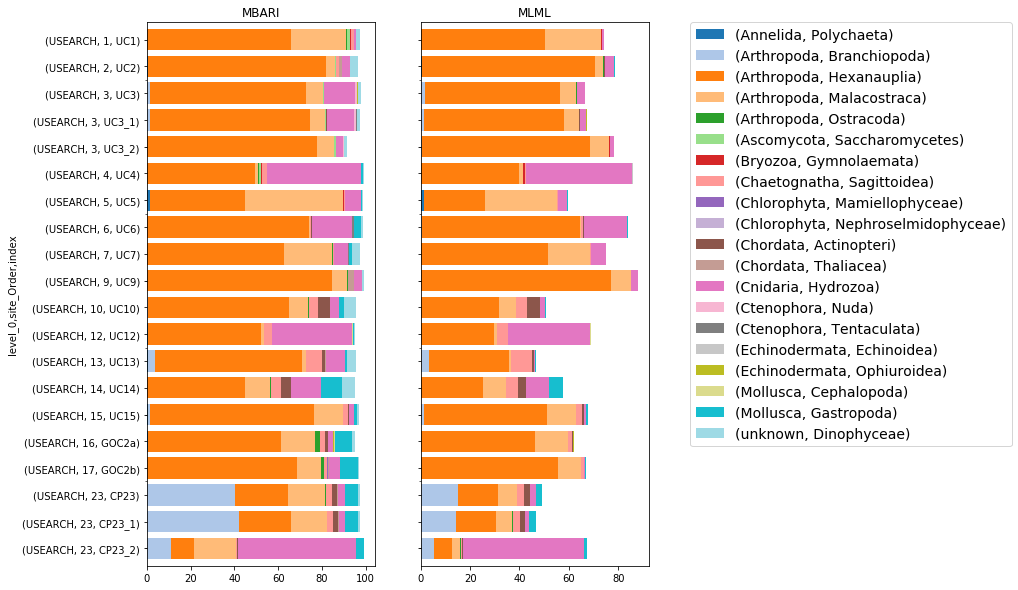

/Users/kpitz/anaconda/lib/python3.5/site-packages/pandas/core/generic.py:3111: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


level_0                                  Banzai     USEARCH
(level_0, , ) (level_1, , )                                
Annelida      Polychaeta               4.618013    2.323681
Arthropoda    Branchiopoda           101.324954   43.311080
              Hexanauplia           1174.380619  868.387845
              Malacostraca           242.024381  171.265556
              Ostracoda                6.034183    1.626036
Ascomycota    Saccharomycetes          4.432488    0.000000
Bryozoa       Gymnolaemata             1.697549    1.888028
Chaetognatha  Sagittoidea             37.733355   35.778797
Chlorophyta   Mamiellophyceae          1.188903    0.027041
              Nephroselmidophyceae     0.392693    0.000000
Chordata      Actinopteri             19.562008   16.595660
              Thaliacea                5.891947    0.000000
Cnidaria      Hydrozoa               244.206612  184.116406
Ctenophora    Nuda                     1.895442    0.000000
              Tentaculata              1.944142    0.000000
Echinodermata Echinoidea               0.275195    0.296244
              Ophiuroidea              1.179626    0.878516
Mollusca      Cephalopoda              0.959316    0.562443
              Gastropoda              53.261752   15.349994
unknown       Dinophyceae             36.209735    0.108162

In [40]:
#Plot by Class and Phylum, fill nan in Ftaxa_COI
from palettable.tableau import Tableau_20 as pr
colors=pr.mpl_colors
cmap=pr.mpl_colormap

print(list(Ftaxa_COI))
#levels = list(Ftaxa_COI)
levels =['Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
grouped = levels[:5]
print(grouped)

df = pd.concat([Geller_COI_otu_comp, Geller_COI_taxa], axis=1)
df=df.loc[df['Class']!='no hits']
df.loc[df['Class']=='Dinophyceae', 'Phylum']='unknown'
df[levels]=df[levels].astype(str)
#group at Family level
#df=df.groupby(levels[:5]).sum()
df=df.groupby(['Phylum','Class']).sum()
df=df.T
df=df.reset_index()
df=df.join(meta_dat[['site_Order']], on='index')
df.set_index(['site_Order', ('index','')], inplace=True)
df=df.T

usearch_df = df.copy()



df = pd.concat([rare_comp_COI, Ftaxa_COI_filt.fillna('not assigned')],  axis=1, join='inner')
df=df.loc[df['Class'].isin(['c_', 'not assigned', 'unknown'])==False]


df[levels]=df[levels].astype(str)

df=df.groupby(['Phylum','Class']).sum()
df=df.T
df=df.reset_index()
df=df.join(meta_dat[['site_Order']], on='index')
df.set_index(['site_Order', ('index','')], inplace=True)
df=df.T

df=pd.concat([df, usearch_df], keys=['Banzai', 'USEARCH'], axis=1)


#Need to make taxa align - no Kingdom level
df=df.reset_index()
#df=df.groupby(levels[1:5]).sum()
#df=df.groupby('Family').sum()
cols = list(df)
df=df.groupby([cols[0], cols[1]]).sum()
df=df.sort_index()
#print(list(df))
print(len(df.index))
#df.reset_index(inplace=True)
#print(df['Phylum'].unique())
#df = df[[('Banzai', 'tot'),('USEARCH', 'tot')]]
df['total']=df.sum(axis=1)
df=df.sort_values('total', ascending=False)
df=df.head(n=20)
#print(list(df))
df.drop(('total', ''), axis=1, inplace=True)
df.sort_index(inplace=True)
df=df.T
df=df.sort_index(ascending=False)
df.reset_index(inplace=True)
df1=df.loc[df['level_0']=='Banzai']
df2=df.loc[df['level_0']=='USEARCH']

df1.set_index(['level_0', 'site_Order', 'index'], inplace=True)
df2.set_index(['level_0', 'site_Order', 'index'], inplace=True)

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)

df1.plot(kind='barh', stacked=True, colors=colors, ax=ax1, legend=False,figsize=(9,10), linewidth=.5, width=0.8)
ax1.set_title('MBARI')
df2.plot(kind='barh', stacked=True, colors=colors, ax=ax2,figsize=(9,10), linewidth=.5, width=0.8)
ax2.set_title('MLML')
plt.legend(bbox_to_anchor=(1.18, 1), loc=2, borderaxespad=0.,ncol=1, fontsize='14')

filename=plot_dir +'GOC_COI_Banzai_Usearch_top20ClassPhy_rare.pdf'
print(filename)
plt.savefig(filename,dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape', papertype=None, format=None,
        transparent=True, bbox_inches='tight', pad_inches=1,
        frameon=None)

plt.show()
df=df.groupby('level_0').sum()
df=df.T
df

# Plot by variable second level (first level at Phylum)

['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
['Phylum', 'Class', 'Order', 'Family', 'Genus']
276


/Users/kpitz/anaconda/lib/python3.5/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)
/Users/kpitz/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:43: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/kpitz/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2662: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
/Users/kpitz/anaconda/lib/python3.5/site-packages/pandas/plotting/_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 

/Users/kpitz/Projects/Gulf_of_California/GOC_18S_COI_Combined_Cutadapt/GOC_COI_Banzai_Usearch_top20SpeciesPhy_rare.pdf


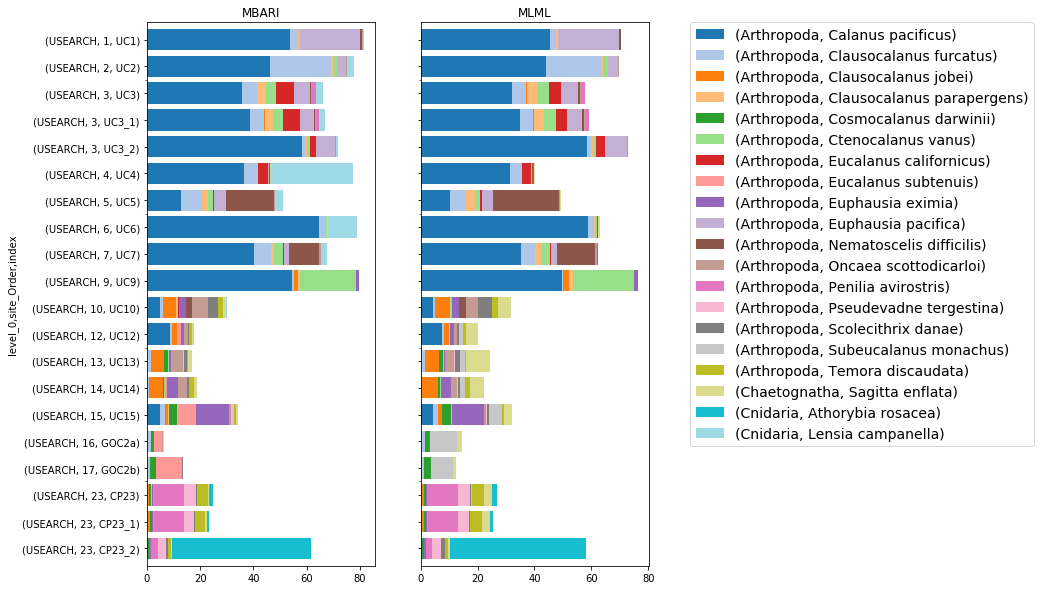

/Users/kpitz/anaconda/lib/python3.5/site-packages/pandas/core/generic.py:3111: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


level_0                                      Banzai     USEARCH
(level_0, , ) (level_1, , )                                    
Arthropoda    Calanus pacificus          460.925458  416.935169
              Clausocalanus furcatus      69.071527   57.203891
              Clausocalanus jobei         21.968414   23.555286
              Clausocalanus parapergens   12.273989   16.950191
              Cosmocalanus darwinii       10.148188   11.296322
              Ctenocalanus vanus          39.794995   41.050494
              Eucalanus californicus      19.950063   15.393259
              Eucalanus subtenuis         22.448459    0.000000
              Euphausia eximia            23.872359   21.828900
              Euphausia pacifica          50.938831   49.785178
              Nematoscelis difficilis     33.724481   41.884543
              Oncaea scottodicarloi       19.868896   14.481694
              Penilia avirostris          27.665561   26.333848
              Pseudevadne tergestina      12.434004   12.279395
              Scolecithrix danae           8.575868   10.617305
              Subeucalanus monachus        0.125229   27.062740
              Temora discaudata           14.734507   15.657655
Chaetognatha  Sagitta enflata              7.235454   35.747550
Cnidaria      Athorybia rosacea           54.843348   50.139108
              Lensia campanella           56.116509    0.000000

In [50]:
#Plot by variable second level (first level at Phylum)
from palettable.tableau import Tableau_20 as pr
colors=pr.mpl_colors
cmap=pr.mpl_colormap

#Set second level to group at, choose one :'Class', 'Order', 'Family', 'Genus', 'Species'
tax_lev = 'Species'
print(list(Ftaxa_COI))
#levels = list(Ftaxa_COI)
levels =['Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
grouped = levels[:5]
print(grouped)

df = pd.concat([Geller_COI_otu_comp, Geller_COI_taxa], axis=1)
df=df.loc[df[tax_lev]!='no hits']
df.loc[df[tax_lev]=='Dinophyceae', 'Phylum']='unknown'
df[levels]=df[levels].astype(str)
#group at Family level
#df=df.groupby(levels[:5]).sum()
df=df.groupby(['Phylum',tax_lev]).sum()
df=df.T
df=df.reset_index()
df=df.join(meta_dat[['site_Order']], on='index')
df.set_index(['site_Order', ('index','')], inplace=True)
df=df.T

usearch_df = df.copy()



df = pd.concat([rare_comp_COI, Ftaxa_COI_filt.fillna('not assigned')],  axis=1, join='inner')
df=df.loc[df[tax_lev].isin(['c_', 'not assigned', 'unknown', 'o_', 'g_', 's_'])==False]


df[levels]=df[levels].astype(str)

df=df.groupby(['Phylum',tax_lev]).sum()
df=df.T
df=df.reset_index()
df=df.join(meta_dat[['site_Order']], on='index')
df.set_index(['site_Order', ('index','')], inplace=True)
df=df.T

df=pd.concat([df, usearch_df], keys=['Banzai', 'USEARCH'], axis=1)


#Need to make taxa align - no Kingdom level
df=df.reset_index()
#df=df.groupby(levels[1:5]).sum()
#df=df.groupby('Family').sum()
cols = list(df)
df=df.groupby([cols[0], cols[1]]).sum()
df=df.sort_index()
#print(list(df))
print(len(df.index))
#df.reset_index(inplace=True)
#print(df['Phylum'].unique())
#df = df[[('Banzai', 'tot'),('USEARCH', 'tot')]]
df['total']=df.sum(axis=1)
df=df.sort_values('total', ascending=False)
df=df.head(n=20)
#print(list(df))
df.drop(('total', ''), axis=1, inplace=True)
df.sort_index(inplace=True)
df=df.T
df=df.sort_index(ascending=False)
df.reset_index(inplace=True)
df1=df.loc[df['level_0']=='Banzai']
df2=df.loc[df['level_0']=='USEARCH']

df1.set_index(['level_0', 'site_Order', 'index'], inplace=True)
df2.set_index(['level_0', 'site_Order', 'index'], inplace=True)

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)

df1.plot(kind='barh', stacked=True, colors=colors, ax=ax1, legend=False,figsize=(9,10), linewidth=.5, width=0.8)
ax1.set_title('MBARI')
df2.plot(kind='barh', stacked=True, colors=colors, ax=ax2,figsize=(9,10), linewidth=.5, width=0.8)
ax2.set_title('MLML')
plt.legend(bbox_to_anchor=(1.18, 1), loc=2, borderaxespad=0.,ncol=1, fontsize='14')

filename=plot_dir +'GOC_COI_Banzai_Usearch_top20'+tax_lev+'Phy_rare.pdf'
print(filename)
plt.savefig(filename,dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape', papertype=None, format=None,
        transparent=True, bbox_inches='tight', pad_inches=1,
        frameon=None)

plt.show()
df=df.groupby('level_0').sum()
df=df.T
df